In [3]:
# purchase_logistic.ipynb

# ## Logistic Regression on Social Network Ads
# This notebook predicts whether a user purchases a product based on Age and Estimated Salary.

# 1. Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report



In [4]:
# 2. Load Dataset
from google.colab import files
uploaded = files.upload()
data = pd.read_csv('Social_Network_Ads.csv')

# 3. Feature Engineering
data['LogAge'] = np.log(data['Age'])
data['Age_squared'] = data['Age']**2
data['Logsal']= np.log(data['EstimatedSalary'])
# Encode Gender: Male = 0, Female = 1
data['Gender_encoded'] = data['Gender'].map({'Male': 0, 'Female': 1})
# Calculate mean salary
mean_salary = data['EstimatedSalary'].mean()

# Create squared deviation from mean
data['Salary_centered_sq'] = ((data['EstimatedSalary'] - mean_salary)**2)

print("Columns:", data.columns)



Saving Social_Network_Ads.csv to Social_Network_Ads.csv
Columns: Index(['User ID', 'Gender', 'Age', 'EstimatedSalary', 'Purchased', 'LogAge',
       'Age_squared', 'Logsal', 'Gender_encoded', 'Salary_centered_sq'],
      dtype='object')


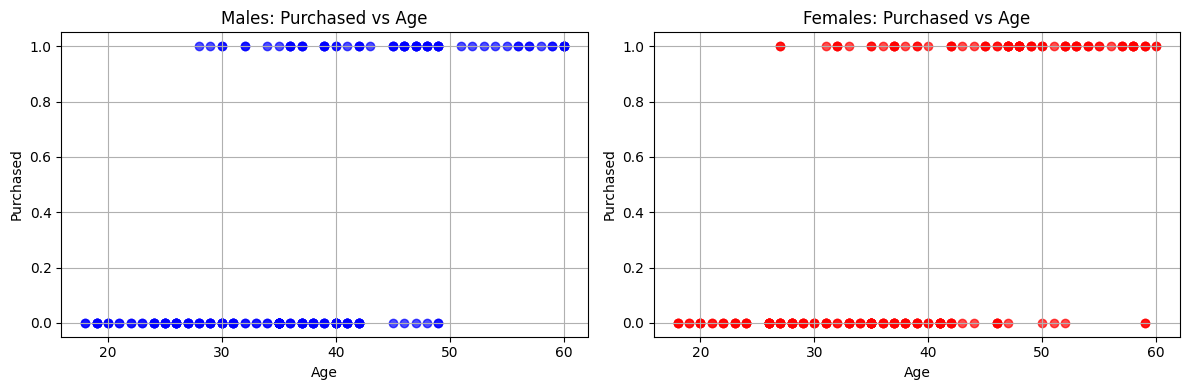

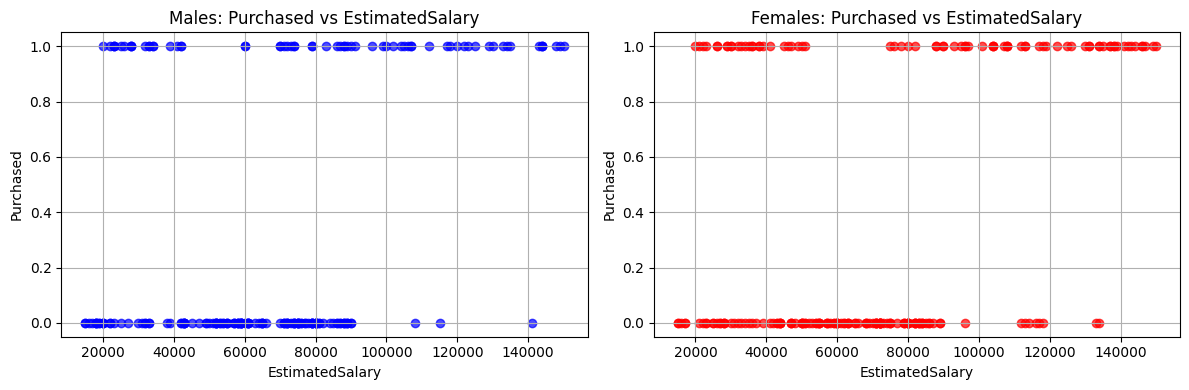

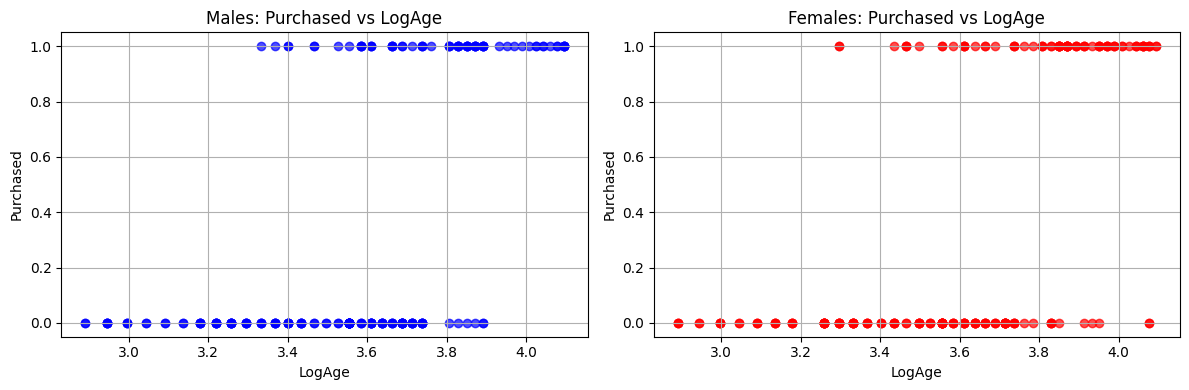

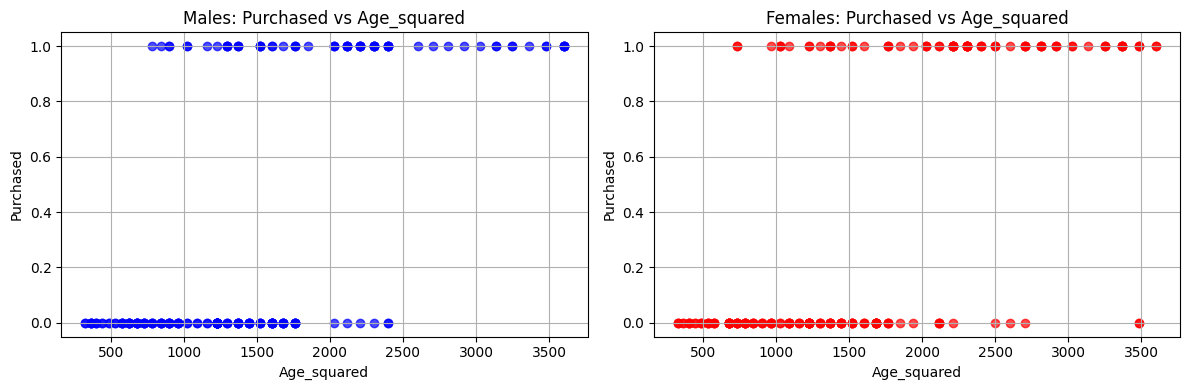

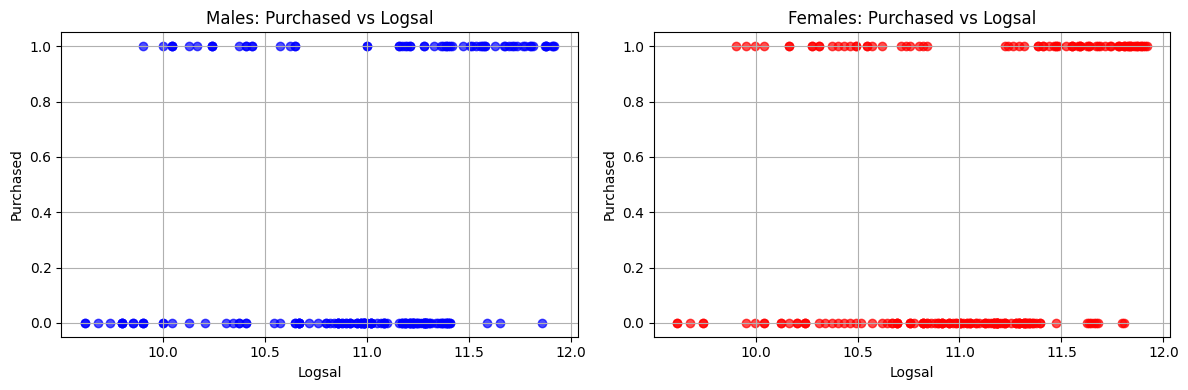

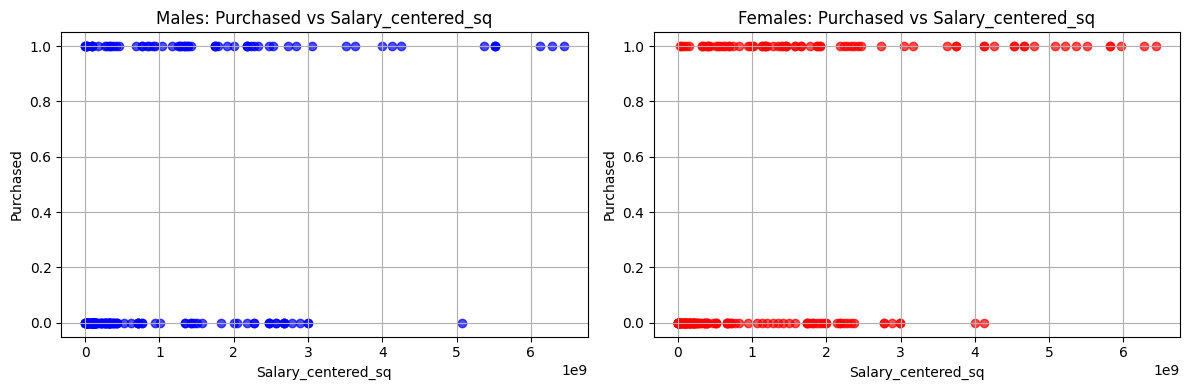

In [5]:


# Features to plot
features = ['Age', 'EstimatedSalary', 'LogAge', 'Age_squared', 'Logsal','Salary_centered_sq']
y = data['Purchased']

# Separate data by gender
male_data = data[data['Gender_encoded'] == 0]
female_data = data[data['Gender_encoded'] == 1]

for feature in features:
    plt.figure(figsize=(12, 4))

    # Plot for Males
    plt.subplot(1, 2, 1)
    plt.scatter(male_data[feature], male_data['Purchased'], color='blue', alpha=0.7)
    plt.title(f'Males: Purchased vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Purchased')
    plt.grid(True)

    # Plot for Females
    plt.subplot(1, 2, 2)
    plt.scatter(female_data[feature], female_data['Purchased'], color='red', alpha=0.7)
    plt.title(f'Females: Purchased vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Purchased')
    plt.grid(True)

    plt.tight_layout()
    plt.show()




/tmp/ipython-input-1580415826.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(win_count.keys(), rotation=45)


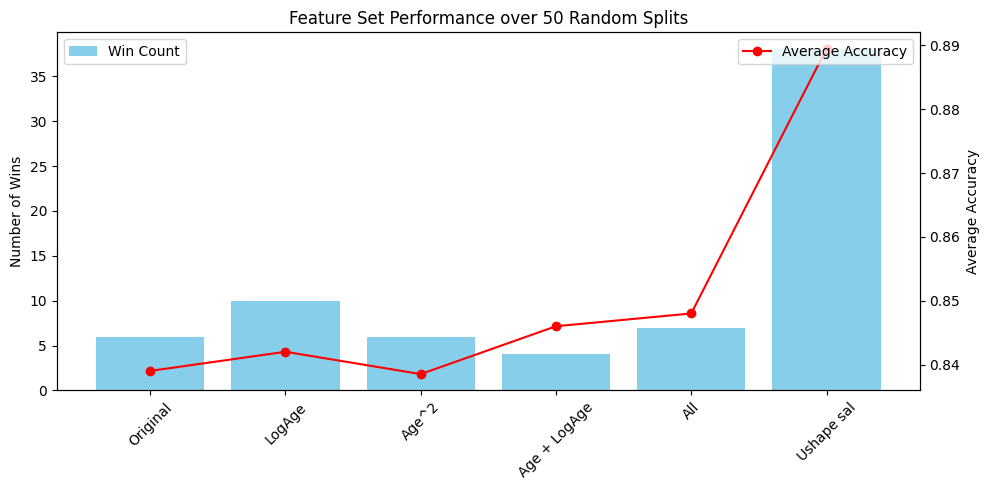

Win counts: {'Original': 6, 'LogAge': 10, 'Age^2': 6, 'Age + LogAge': 4, 'All': 7, 'Ushape sal': 38}
Average accuracy: {'Original': 0.839, 'LogAge': 0.8419999999999997, 'Age^2': 0.8384999999999998, 'Age + LogAge': 0.8459999999999996, 'All': 0.8479999999999995, 'Ushape sal': 0.8894999999999998}


In [6]:


# 4. Define linear feature sets
feature_sets = {
    "Original": ['Age', 'EstimatedSalary'],
    "LogAge": ['LogAge', 'EstimatedSalary'],
    "Age^2": ['Age_squared', 'EstimatedSalary'],
    "Age + LogAge": ['Age', 'LogAge', 'EstimatedSalary'],
    "All": ['Age', 'Age_squared', 'LogAge', 'EstimatedSalary'],
    "Ushape sal": ['Age', 'Salary_centered_sq']
}

# 5. Run for multiple random states
n_runs = 50  # Number of random splits
win_count = {name: 0 for name in feature_sets}
accuracy_sum = {name: 0 for name in feature_sets}

for rs in range(n_runs):
    accuracies = {}
    for name, features in feature_sets.items():
        X = data[features]
        y = data['Purchased']

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rs)

        # Scale features
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train logistic regression
        model = LogisticRegression(fit_intercept=True)
        model.fit(X_train_scaled, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, y_pred)
        accuracies[name] = acc
        accuracy_sum[name] += acc

    # Find feature set(s) with max accuracy for this run
    max_acc = max(accuracies.values())
    winners = [name for name, acc in accuracies.items() if acc == max_acc]

    for winner in winners:
        win_count[winner] += 1

# Calculate average accuracy
average_accuracy = {name: accuracy_sum[name]/n_runs for name in feature_sets}

# 6. Plot results
fig, ax1 = plt.subplots(figsize=(10,5))

# Bar plot for win counts
ax1.bar(win_count.keys(), win_count.values(), color='skyblue', label='Win Count')
ax1.set_ylabel('Number of Wins')
ax1.set_xticklabels(win_count.keys(), rotation=45)
ax1.set_title(f"Feature Set Performance over {n_runs} Random Splits")

# Line plot for average accuracy on same plot
ax2 = ax1.twinx()
ax2.plot(list(average_accuracy.keys()), list(average_accuracy.values()), color='red', marker='o', label='Average Accuracy')
ax2.set_ylabel('Average Accuracy')

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print results
print("Win counts:", win_count)
print("Average accuracy:", average_accuracy)



Best Feature Set: Ushape sal
Confusion Matrix:
 [[26  1]
 [ 4  9]]

Accuracy: 0.875

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91        27
           1       0.90      0.69      0.78        13

    accuracy                           0.88        40
   macro avg       0.88      0.83      0.85        40
weighted avg       0.88      0.88      0.87        40



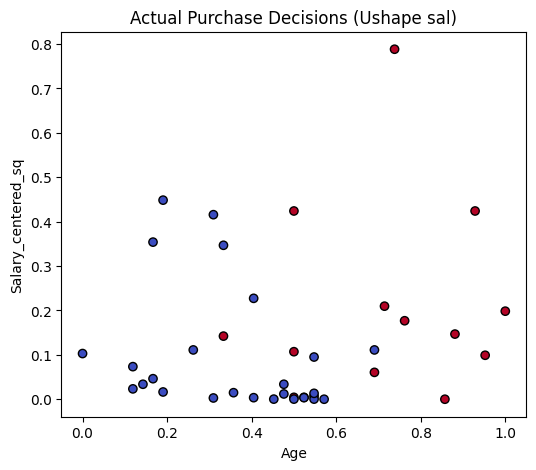

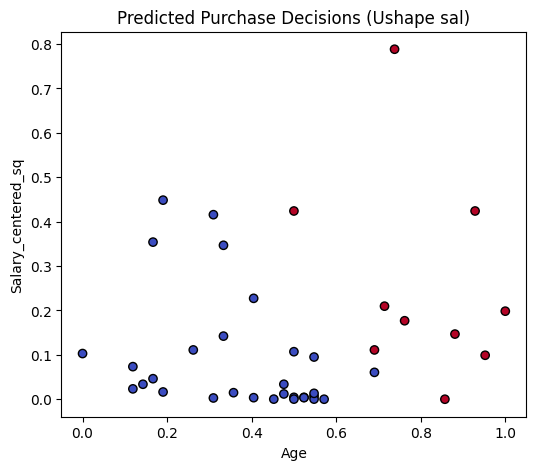

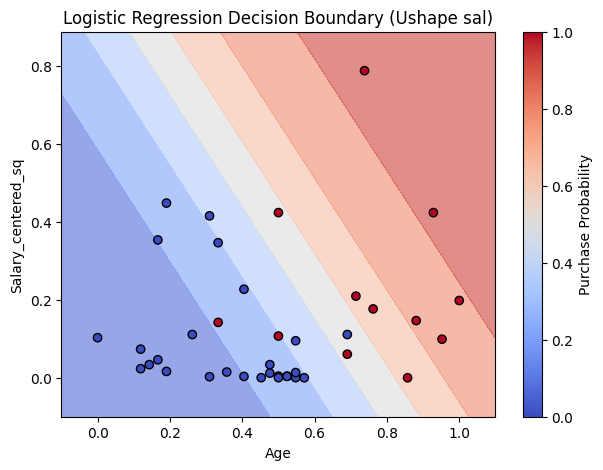

In [7]:

# 8. Best linear model evaluation (refit best model once)
best_linear_name = max(average_accuracy, key=average_accuracy.get)
features_lin = feature_sets[best_linear_name]
print(f"\nBest Feature Set: {best_linear_name}")

# Refit on one fixed random state
X = data[features_lin]
y = data['Purchased']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=51)

scaler_lin = MinMaxScaler()
X_train_scaled = scaler_lin.fit_transform(X_train)
X_test_scaled = scaler_lin.transform(X_test)

model_lin = LogisticRegression(fit_intercept=True)
model_lin.fit(X_train_scaled, y_train)
y_pred_lin = model_lin.predict(X_test_scaled)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lin))
print("\nAccuracy:", accuracy_score(y_test, y_pred_lin))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lin))

# 9. Visualize actual vs predicted
plt.figure(figsize=(6,5))
plt.scatter(X_test_scaled[:,0], X_test_scaled[:,1], c=y_test, cmap='coolwarm', edgecolors='k')
plt.title(f'Actual Purchase Decisions ({best_linear_name})')
plt.xlabel(features_lin[0])
plt.ylabel(features_lin[1])
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(X_test_scaled[:,0], X_test_scaled[:,1], c=y_pred_lin, cmap='coolwarm', edgecolors='k')
plt.title(f'Predicted Purchase Decisions ({best_linear_name})')
plt.xlabel(features_lin[0])
plt.ylabel(features_lin[1])
plt.show()

# 10. Decision boundary (only if 2 features)
if len(features_lin) == 2:
    x_min, x_max = X_test_scaled[:,0].min() - 0.1, X_test_scaled[:,0].max() + 0.1
    y_min, y_max = X_test_scaled[:,1].min() - 0.1, X_test_scaled[:,1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    Z = model_lin.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1].reshape(xx.shape)

    plt.figure(figsize=(7,5))
    plt.contourf(xx, yy, Z, alpha=0.6, cmap='coolwarm')
    plt.scatter(X_test_scaled[:,0], X_test_scaled[:,1], c=y_test, edgecolors='k', cmap='coolwarm')
    plt.title(f'Logistic Regression Decision Boundary ({best_linear_name})')
    plt.xlabel(features_lin[0])
    plt.ylabel(features_lin[1])
    plt.colorbar(label='Purchase Probability')
    plt.show()


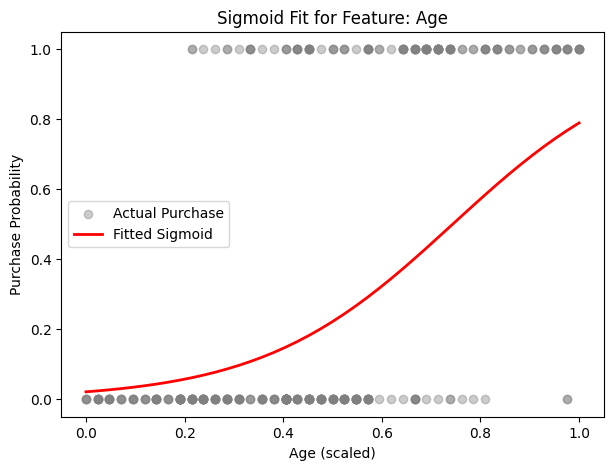

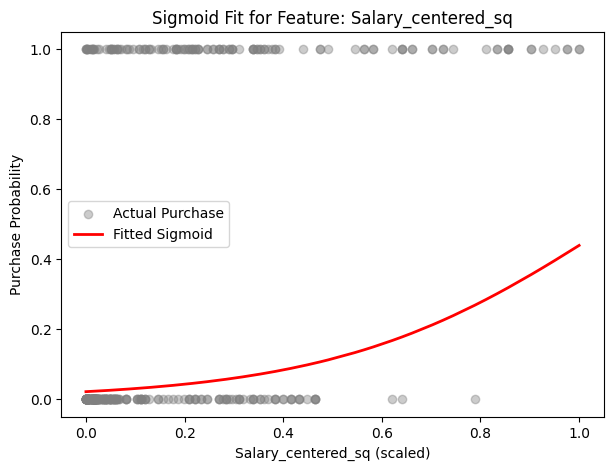

In [9]:
# 11. Plot individual sigmoid fits for each feature in the best model (using all training data)
from scipy.special import expit  # Sigmoid function

# Extract model coefficients and intercept
coefs = model_lin.coef_[0]
intercept = model_lin.intercept_[0]

# Loop through each feature in the best model
for i, feature in enumerate(features_lin):
    X_feature = X_train[feature].values.reshape(-1, 1)
    y_true = y_train.values

    # Scale feature using the same scaler
    X_scaled_full = scaler_lin.transform(X_train)
    X_feature_scaled = X_scaled_full[:, i]

    # Sort for smooth plotting
    sorted_idx = np.argsort(X_feature_scaled)
    X_sorted = X_feature_scaled[sorted_idx]
    y_sorted = y_true[sorted_idx]

    # Compute sigmoid curve
    z = intercept + coefs[i] * X_sorted
    y_pred_prob = expit(z)

    # Plot actual data points and sigmoid curve
    plt.figure(figsize=(7,5))
    plt.scatter(X_feature_scaled, y_true, color='gray', alpha=0.4, label='Actual Purchase')
    plt.plot(X_sorted, y_pred_prob, color='red', linewidth=2, label='Fitted Sigmoid')
    plt.title(f"Sigmoid Fit for Feature: {feature}")
    plt.xlabel(f"{feature} (scaled)")
    plt.ylabel("Purchase Probability")
    plt.legend()
    plt.show()
